# Crowd prediction based on trip chaining results enhanced for providing the results for the quantitative analysis of the mobility model card. 

Predicts #Entries & #Exits per zone, day of the week and timewindow 

In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Asimina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Imports

In [2]:
import datetime;from datetime import timedelta;import pandas as pd;import math;import numpy as np;
import matplotlib.pyplot as plt;import math; from math import radians, sin, cos, sqrt, atan2;import time; 
from sklearn.preprocessing import MinMaxScaler;from sklearn.model_selection import train_test_split; 
import tensorflow as tf
from tensorflow.keras.models import Sequential;from tensorflow.keras.layers import Dense, Activation, Flatten;from tensorflow.keras import optimizers;
from sklearn import datasets, linear_model;from sklearn.model_selection import cross_val_score, KFold;
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score; import tensorflow as tf
from tensorflow import keras; from tensorflow.keras import layers;from tensorflow.keras.callbacks import ReduceLROnPlateau;import joblib

###  NN development 

In [3]:
df6 = pd.read_csv("Data/A_df.csv", sep=",", encoding='utf-8')
df6.tail(2)

,Unnamed: 0,EntryStop_Zone,datetime_day_week,datetime_W,m_entries,m_exits
52899,52899,Šķirotava,7,79,5.111111,4.555556
52900,52900,Šķirotava,7,80,3.000000,2.500000


In [4]:
new_order = ['datetime_day_week', 'datetime_W','EntryStop_Zone', 'm_entries','m_exits']
df6 = df6[new_order]

In [5]:
# Define feature columns
num_cols = ['datetime_day_week', 'datetime_W']  # First two columns numerical features to be scaled
em_col = ['zone_codes']  #column for embedding
target_col = ['m_entries', 'm_exits']       ### NEW: list of two targets

In [6]:
df6['EntryStop_Zone'].nunique()

133

In [7]:
# Normalize time features (Min-Max Scaling)
scaler = MinMaxScaler()
df6[num_cols] = scaler.fit_transform(df6[num_cols])

In [8]:
df6.head(2)

,datetime_day_week,datetime_W,EntryStop_Zone,m_entries,m_exits
0,0.0,0.152941,Acone #1,2.500000,2.500000
1,0.0,0.188235,Acone #1,2.444444,2.444444


In [9]:
df6.shape

(52901, 5)

In [10]:
#string to integer
df6["EntryStop_Zone"] = df6["EntryStop_Zone"].astype("category")
df6["zone_codes"] = df6["EntryStop_Zone"].cat.codes

In [11]:
zone_categories = df6["EntryStop_Zone"].cat.categories  # returns an Index of category labels

In [12]:
forward_zone_map = {zone_label: i for i, zone_label in enumerate(zone_categories)}
reverse_zone_map = {i: zone_label for i, zone_label in enumerate(zone_categories)}
joblib.dump(forward_zone_map, 'forward_zone_map.joblib')
joblib.dump(reverse_zone_map, 'reverse_zone_map.joblib')

['reverse_zone_map.joblib']

In [13]:
print(df6.dtypes)

datetime_day_week     float64
datetime_W            float64
EntryStop_Zone       category
m_entries             float64
m_exits               float64
zone_codes              int16
dtype: object


In [14]:
df6.tail(2)

,datetime_day_week,datetime_W,EntryStop_Zone,m_entries,m_exits,zone_codes
52899,1.0,0.823529,Šķirotava,5.111111,4.555556,132
52900,1.0,0.835294,Šķirotava,3.000000,2.500000,132


In [15]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    df6[num_cols + em_col], df6[target_col], test_size=0.2, random_state=42
)

In [16]:
# Convert DataFrame to NumPy arrays
X_train_num = np.array(X_train[num_cols])  # Time features remain 2D
X_train_em = np.array(X_train[em_col]).reshape(-1, 1)  # Reshape stop_id for embedding

X_test_num = np.array(X_test[num_cols])
X_test_em = np.array(X_test[em_col]).reshape(-1, 1)

y_train_raw = np.asarray(y_train_raw).astype("float32")  # shape (n, 2)
y_test_raw  = np.asarray(y_test_raw).astype("float32")

In [17]:
y_train = y_train_raw.astype("float32")
y_test  = y_test_raw.astype("float32")

In [18]:
###################################################################

In [19]:
# Weight for large value predictions

In [20]:
# Row-level weight = sqrt(max(entries, exits))      (sqrt tames outliers a bit)
row_weight = np.sqrt(np.max(y_train_raw, axis=1))
row_weight = (row_weight / row_weight.mean()).astype("float32")
print(f"Mean sample-weight = {row_weight.mean():.2f}")

Mean sample-weight = 1.00


In [21]:
#Log for small values predictions:
#Instead of using   y_train = np.log1p(y_train_raw) & y_test  = np.log1p(y_test_raw), include the log in the loss:  loss=keras.losses.MeanSquaredLogarithmicError()

In [22]:
##################################################################

In [23]:
# Define input layers
num_input = keras.Input(shape=(2,), name="num_input")  # First two columns (num scaled features)
em_input = keras.Input(shape=(1,), name="em_input")  # Fourth column (categorical zone for embedding)

# Embedding layer for zone (assuming max 133 unique zones)
embedding_dim = 48  # Tuneable hyperparameter
zone_embedding = layers.Embedding(input_dim=133, output_dim=embedding_dim)(em_input)
zone_embedding = layers.Flatten()(zone_embedding)  # Flatten the embeddings

# Concatenate stop embeddings with time features
merged = layers.Concatenate()([num_input, zone_embedding])

# Fully connected layers
x = layers.Dense(128, activation="relu")(merged)   # wider
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
output = layers.Dense(2, activation="linear")(x)

# Define the model
model = keras.Model(inputs=[num_input, em_input], outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.MeanSquaredLogarithmicError(),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)


# Learning rate scheduler to reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ em_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 48)     │      6,384 │ em_input[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 48)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50)        │          0 │ num_input[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      6,528 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │         34 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,578 (96.01 KB)

 Trainable params: 24,194 (94.51 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.0149 - mae: 14.9421 - val_loss: 0.7657 - val_mae: 14.5692 - learning_rate: 0.0050
Epoch 2/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2433 - mae: 8.7566 - val_loss: 0.3192 - val_mae: 7.7042 - learning_rate: 0.0050
Epoch 3/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2160 - mae: 8.3122 - val_loss: 0.2983 - val_mae: 7.1439 - learning_rate: 0.0050
Epoch 4/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2011 - mae: 7.8103 - val_loss: 0.2472 - val_mae: 6.9146 - learning_rate: 0.0050
Epoch 5/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1968 - mae: 7.8043 - val_loss: 0.2628 - val_mae: 7.1474 - learning_rate: 0.0050
Epoch 6/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2060 - mae: 8.0685 - val_loss: 0.2534 - val_mae: 6.5872 - learning_rate: 0.0050
Epoch 7/200
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1924 - mae: 7.5969 - val_loss: 0.2452 - val_mae: 6.8211 - learning_rate

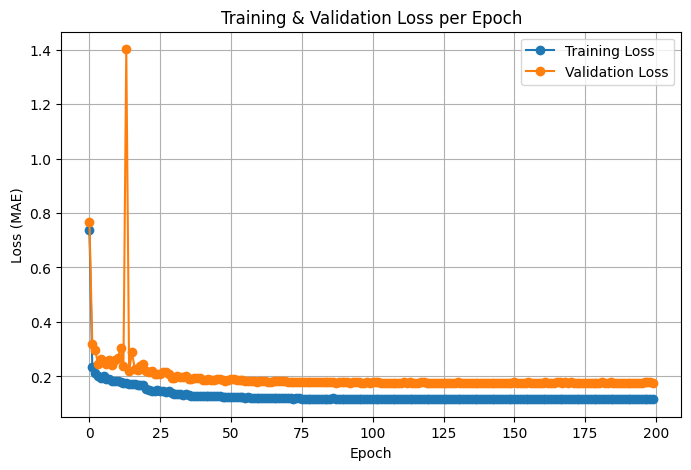

In [24]:
# Train the model and store history

history = model.fit(
    [X_train_num, X_train_em], y_train, sample_weight=row_weight,         
    validation_data=([X_test_num, X_test_em], y_test),
    epochs=200, batch_size=128,  callbacks=[lr_scheduler], verbose=1
)


# Plot loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MΑE)')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Evaluate on test set
loss, mae = model.evaluate([X_test_num, X_test_em], y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1834 - mae: 5.1009
Test Loss: 0.1771, Test MAE: 5.0122


In [26]:
y_pred = model.predict([X_test_num, X_test_em])
mae_entries = np.mean(np.abs(y_test[:,0] - y_pred[:,0]))
mae_exits   = np.mean(np.abs(y_test[:,1] - y_pred[:,1]))
print(f"Entries MAE: {mae_entries:.4f} | Exits MAE: {mae_exits:.4f}")

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Entries MAE: 5.2956 | Exits MAE: 4.7288


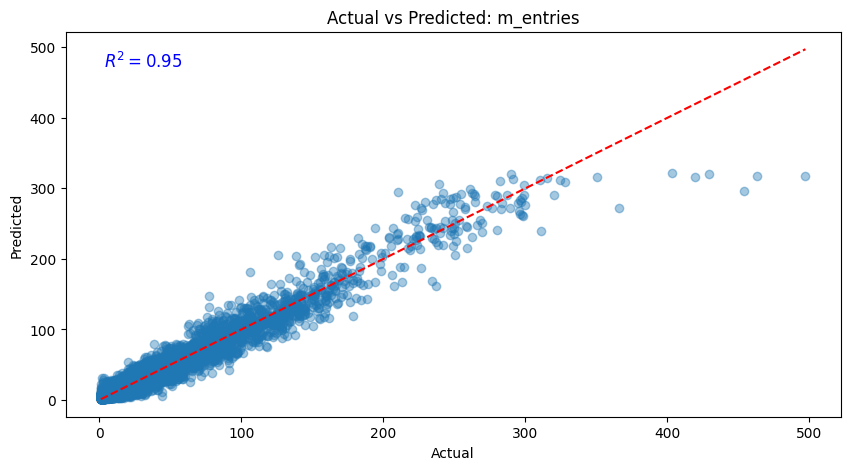

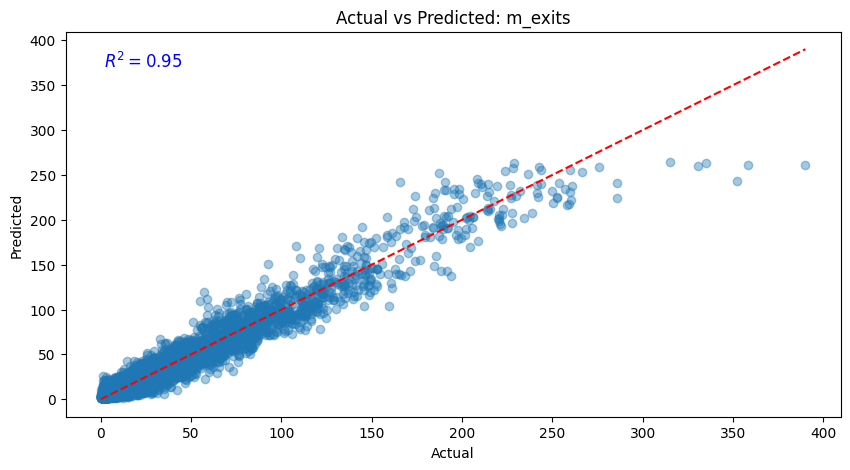

In [27]:
# Plot for each target
for i, label in enumerate(target_col):
    plt.figure(figsize=(10,5))
    r2 = r2_score(y_test[:,i], y_pred[:,i])
    plt.scatter(y_test[:,i], y_pred[:,i], alpha=0.4)
    lims = [min(y_test[:,i].min(), y_pred[:,i].min()),
            max(y_test[:,i].max(), y_pred[:,i].max())]
    plt.plot(lims, lims, 'r--')
    plt.title(f"Actual vs Predicted: {label}")
    plt.annotate(f'$R^2 = {r2:.2f}$', xy=(0.05, 0.95),xycoords='axes fraction',fontsize=12,color='blue', verticalalignment='top')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

In [28]:
#Visualize predicted vs real number of people per stop on test set

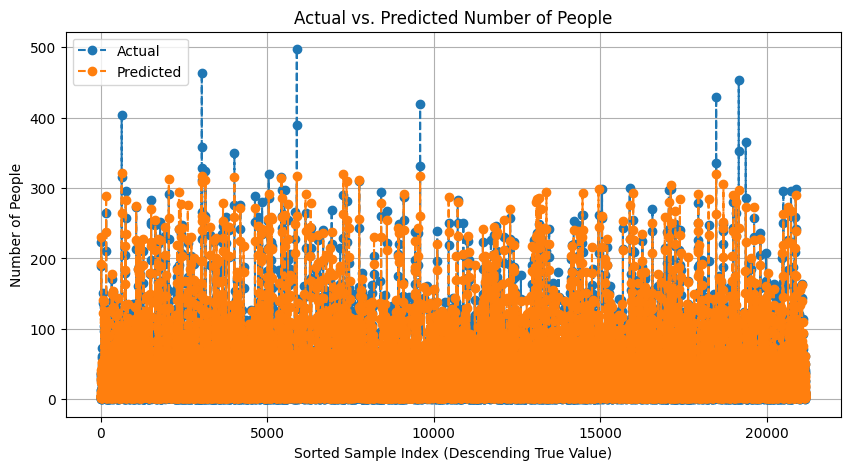

In [29]:
# Flatten arrays
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_flat, label="Actual", marker='o', linestyle='dashed')
plt.plot(y_pred_flat, label="Predicted", marker='o', linestyle='dashed')
plt.xlabel("Sorted Sample Index (Descending True Value)")
plt.ylabel("Number of People")
plt.title("Actual vs. Predicted Number of People")
plt.legend()
plt.grid(True)
plt.show()

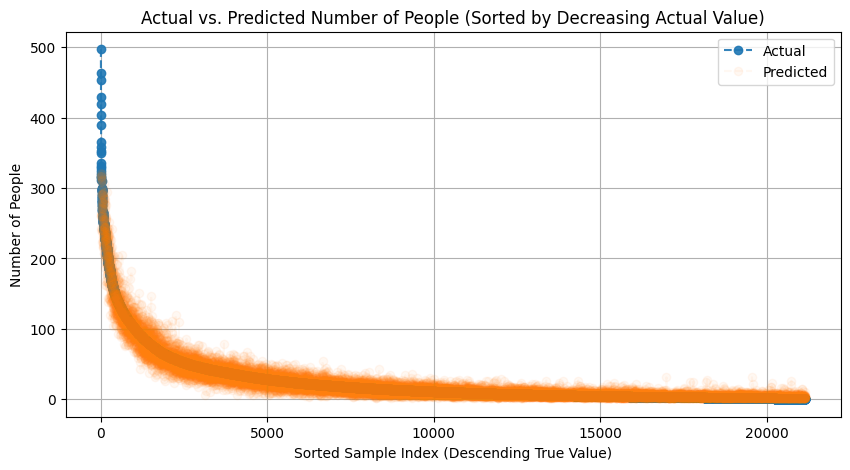

In [30]:
# Sort indices based on decreasing actual values
sorted_indices = np.argsort(-y_test_flat)  # Negative sign to sort in decreasing order

# Apply sorting
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_flat[sorted_indices]

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label="Actual", marker='o', linestyle='dashed',alpha=0.9)
plt.plot(y_pred_sorted, label="Predicted", marker='o', linestyle='dashed',alpha=0.05)
plt.xlabel("Sorted Sample Index (Descending True Value)")
plt.ylabel("Number of People")
plt.title("Actual vs. Predicted Number of People (Sorted by Decreasing Actual Value)")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# -------------------------------------------------------
# Predict on a new sample
# -------------------------------------------------------
sample_num = np.array([[0.5, 0.3]], dtype="float32")
sample_em  = np.array([[100]], dtype="int32")
pred_sample = model.predict([sample_num, sample_em])[0]                               
print(f"Predicted entries: {pred_sample[0]:.1f}, exits: {pred_sample[1]:.1f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Predicted entries: 11.1, exits: 10.7


#######################################################################

In [32]:
#######################################################################

### Save model

In [33]:
model.save('NN_En_Ex.h5')

### Quantitative Analysis:

Unitary results

In [34]:
# Get back the original unscaled features for the test set
X_test_original = X_test.copy()
X_test_original[num_cols] = scaler.inverse_transform(X_test[num_cols])  # unscale

# Build DataFrames
df_num = X_test_original[num_cols].reset_index(drop=True)
df_em = X_test_original[em_col].reset_index(drop=True)  # already not scaled
df_y_test = pd.DataFrame(y_test_raw, columns=['y_true_entries', 'y_true_exits']).reset_index(drop=True)
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred_entries', 'y_pred_exits']).reset_index(drop=True)

# Combine all into one
df_all_unscaled = pd.concat([df_num, df_em, df_y_test, df_y_pred], axis=1)
df_all_unscaled.head()


,datetime_day_week,datetime_W,zone_codes,y_true_entries,y_true_exits,y_pred_entries,y_pred_exits
0,3.0,64.0,36,2.000000,2.000000,4.195545,4.010705
1,5.0,80.0,93,5.636364,4.636364,3.260321,3.074721
2,7.0,69.0,9,2.888889,2.666667,4.371271,4.072470
3,5.0,73.0,43,35.642857,31.785715,29.112879,24.998581
4,5.0,18.0,119,1.000000,0.500000,2.055966,1.851573


In [42]:
from sklearn.metrics import mean_absolute_error

def evaluate_multidim_outputs_by_group(df, group_col, y_true_cols, y_pred_cols, metric_func):
    results = []
    for group, group_df in df.groupby(group_col):
        entry_score = metric_func(group_df[y_true_cols[0]], group_df[y_pred_cols[0]])
        exit_score = metric_func(group_df[y_true_cols[1]], group_df[y_pred_cols[1]])
        results.append({
            group_col: group,
            f'{y_true_cols[0]}_score': entry_score,
            f'{y_true_cols[1]}_score': exit_score
        })
    return pd.DataFrame(results)

mae_by_day_week = evaluate_multidim_outputs_by_group(
    df_all_unscaled, group_col='datetime_day_week',
    y_true_cols=['y_true_entries', 'y_true_exits'],
    y_pred_cols=['y_pred_entries', 'y_pred_exits'],
    metric_func=mean_absolute_error
)
mae_by_datetime_W = evaluate_multidim_outputs_by_group(
    df_all_unscaled, group_col='datetime_W',
    y_true_cols=['y_true_entries', 'y_true_exits'],
    y_pred_cols=['y_pred_entries', 'y_pred_exits'],
    metric_func=mean_absolute_error
)
mae_by_zone_codes = evaluate_multidim_outputs_by_group(
    df_all_unscaled, group_col='zone_codes',
    y_true_cols=['y_true_entries', 'y_true_exits'],
    y_pred_cols=['y_pred_entries', 'y_pred_exits'],
    metric_func=mean_absolute_error
)
print(mae_by_day_week, mae_by_datetime_W, mae_by_zone_codes)

   datetime_day_week  y_true_entries_score  y_true_exits_score
0                1.0              5.295033            4.720369
1                2.0              5.086748            4.628552
2                3.0              5.346359            4.767142
3                4.0              5.526356            4.944904
4                5.0              5.486233            4.882710
5                6.0              5.764511            5.125236
6                7.0              4.573494            4.031384     datetime_W  y_true_entries_score  y_true_exits_score
0         10.0              1.163572            1.590241
1         13.0              0.993334            0.712741
2         14.0              1.452627            1.334429
3         15.0              1.855402            1.601543
4         16.0              0.869629            0.947370
..         ...                   ...                 ...
77        89.0              0.972046            1.016165
78        90.0              6.432464    

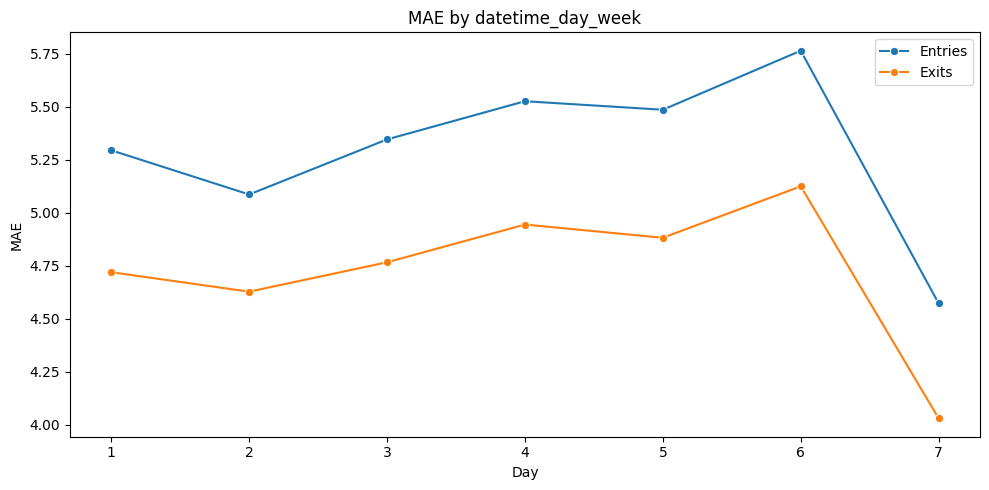

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=mae_by_day_week, x='datetime_day_week', y='y_true_entries_score', label='Entries', marker='o')
sns.lineplot(data=mae_by_day_week, x='datetime_day_week', y='y_true_exits_score', label='Exits', marker='o')
plt.title('MAE by datetime_day_week')
plt.xlabel('Day')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


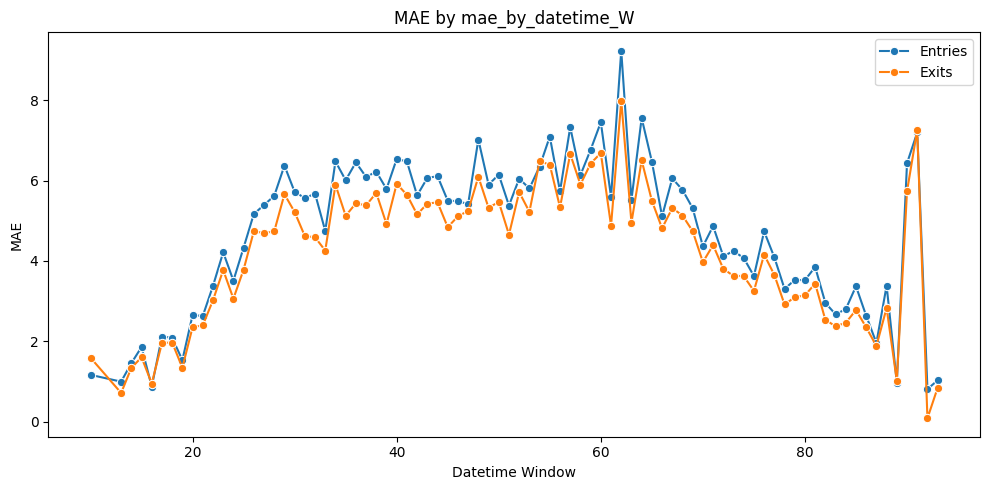

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=mae_by_datetime_W, x='datetime_W', y='y_true_entries_score', label='Entries', marker='o')
sns.lineplot(data=mae_by_datetime_W, x='datetime_W', y='y_true_exits_score', label='Exits', marker='o')
plt.title('MAE by mae_by_datetime_W')
plt.xlabel('Datetime Window')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


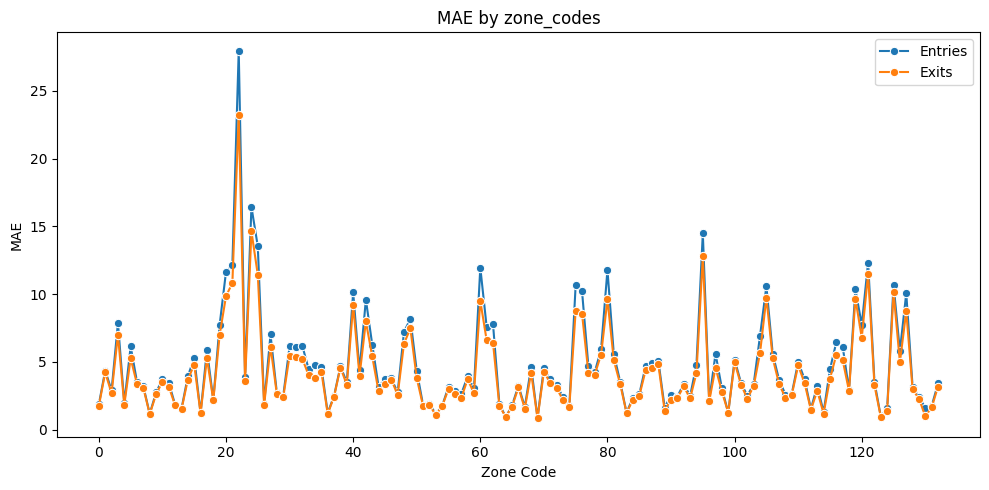

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=mae_by_zone_codes, x='zone_codes', y='y_true_entries_score', label='Entries', marker='o')
sns.lineplot(data=mae_by_zone_codes, x='zone_codes', y='y_true_exits_score', label='Exits', marker='o')
plt.title('MAE by zone_codes')
plt.xlabel('Zone Code')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Intersectional result

In [47]:
# Helper function (already fixed for multiple group columns)
from sklearn.metrics import mean_absolute_error

def evaluate_multidim_outputs_by_group(df, group_col, y_true_cols, y_pred_cols, metric_func):
    results = []
    for group, group_df in df.groupby(group_col):
        entry_score = metric_func(group_df[y_true_cols[0]], group_df[y_pred_cols[0]])
        exit_score = metric_func(group_df[y_true_cols[1]], group_df[y_pred_cols[1]])
        
        # Handle single vs multiple grouping columns
        if isinstance(group, tuple):
            group_dict = {col: val for col, val in zip(group_col, group)}
        else:
            group_dict = {group_col: group}
        
        group_dict.update({
            f'{y_true_cols[0]}_score': entry_score,
            f'{y_true_cols[1]}_score': exit_score
        })
        results.append(group_dict)
    
    return pd.DataFrame(results)

# 1. Zone × Day of Week
mae_by_zone_day = evaluate_multidim_outputs_by_group(
    df_all_unscaled,
    group_col=['zone_codes','datetime_day_week'],
    y_true_cols=['y_true_entries','y_true_exits'],
    y_pred_cols=['y_pred_entries','y_pred_exits'],
    metric_func=mean_absolute_error
)

# 2. Zone × Time Window
mae_by_zone_time = evaluate_multidim_outputs_by_group(
    df_all_unscaled,
    group_col=['zone_codes','datetime_W'],
    y_true_cols=['y_true_entries','y_true_exits'],
    y_pred_cols=['y_pred_entries','y_pred_exits'],
    metric_func=mean_absolute_error
)

# 3. Day of Week × Time Window
mae_by_day_time = evaluate_multidim_outputs_by_group(
    df_all_unscaled,
    group_col=['datetime_day_week','datetime_W'],
    y_true_cols=['y_true_entries','y_true_exits'],
    y_pred_cols=['y_pred_entries','y_pred_exits'],
    metric_func=mean_absolute_error
)

# Show previews
print("Zone × Day of Week:\n", mae_by_zone_day.head(10))
print("Zone × Time Window:\n", mae_by_zone_time.head(10))
print("Day of Week × Time Window:\n", mae_by_day_time.head(10))


Zone × Day of Week:
    zone_codes  datetime_day_week  y_true_entries_score  y_true_exits_score
0           0                1.0              2.168679            2.094001
1           0                2.0              1.546949            1.317632
2           0                3.0              2.686394            2.547713
3           0                4.0              2.045203            1.852513
4           0                5.0              2.056967            2.021225
5           0                6.0              1.572039            1.520867
6           0                7.0              0.961412            0.836210
7           1                1.0              5.162105            4.939957
8           1                2.0              5.157670            4.979734
9           1                3.0              4.071763            4.117407
Zone × Time Window:
    zone_codes  datetime_W  y_true_entries_score  y_true_exits_score
0           0        25.0              0.485037            0.8591

In [ ]:
# Ensure day-of-week is integer [0–6]
mae_by_zone_day["datetime_day_week"] = mae_by_zone_day["datetime_day_week"].round().astype(int)

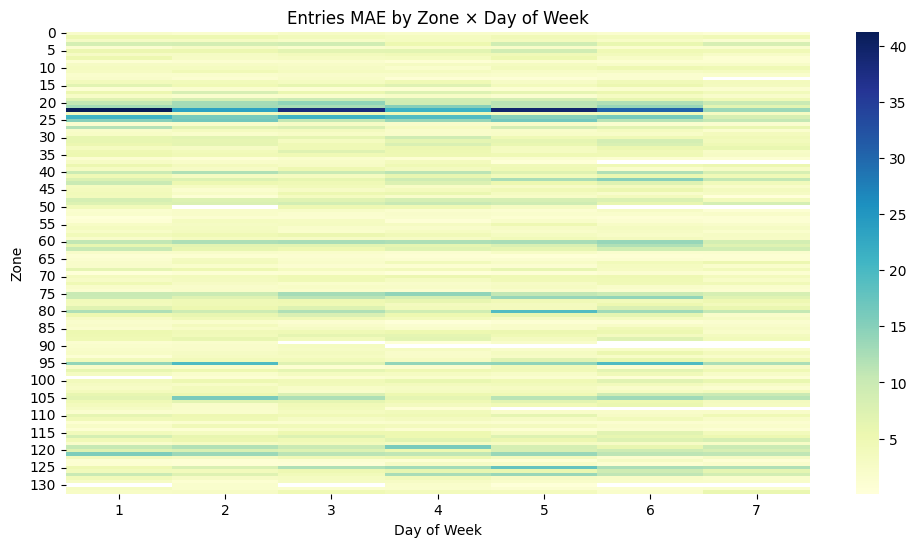

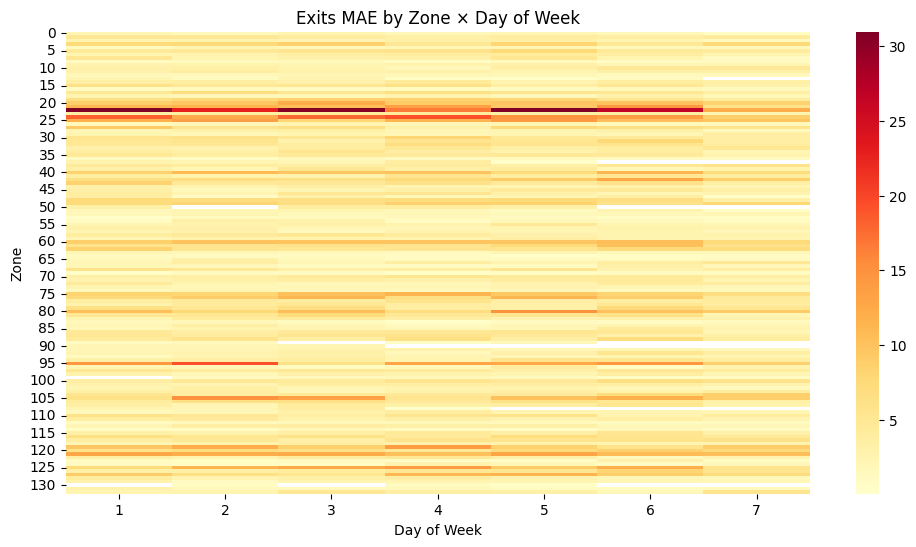

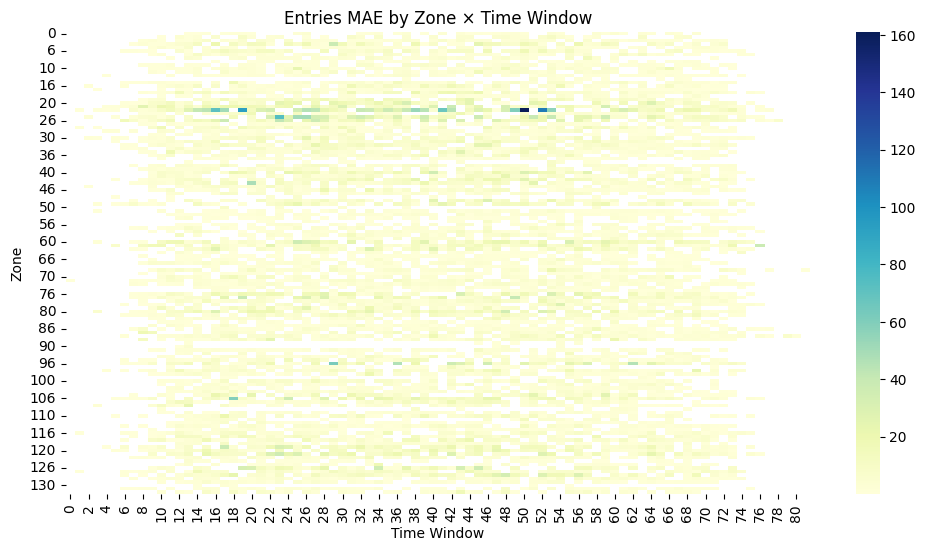

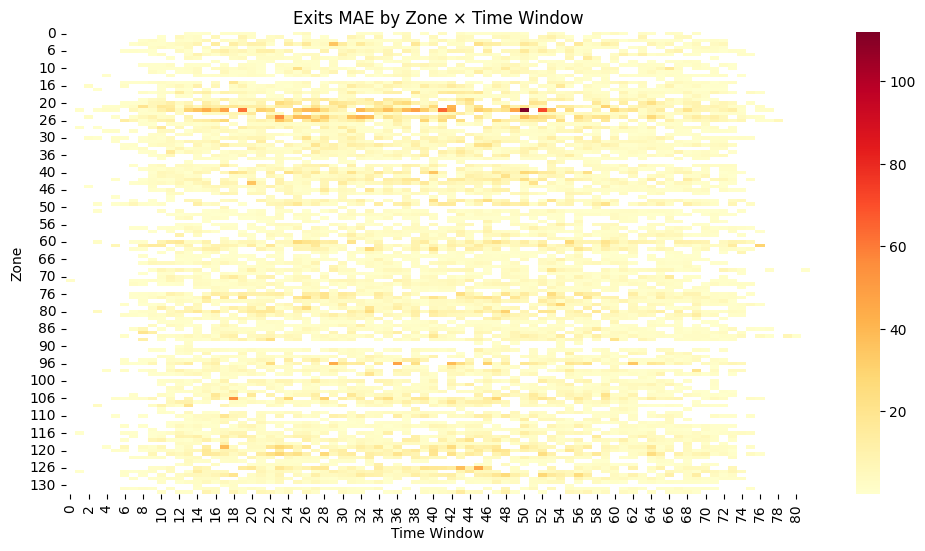

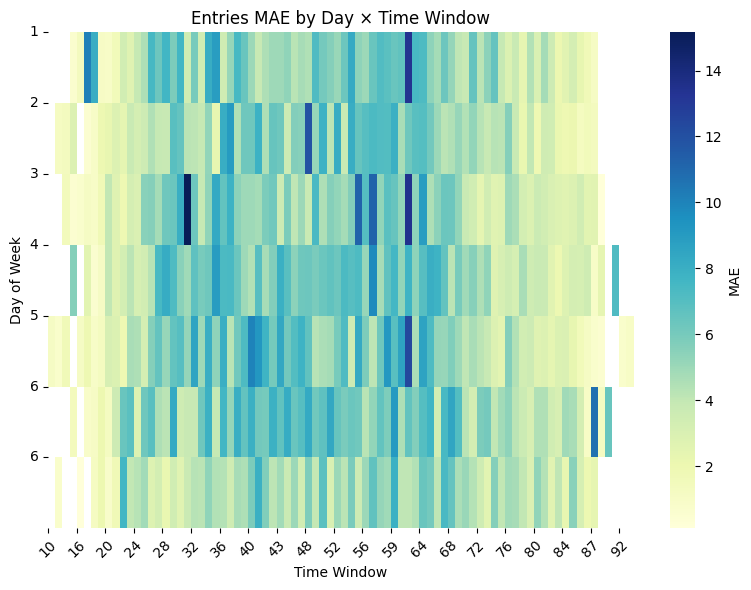

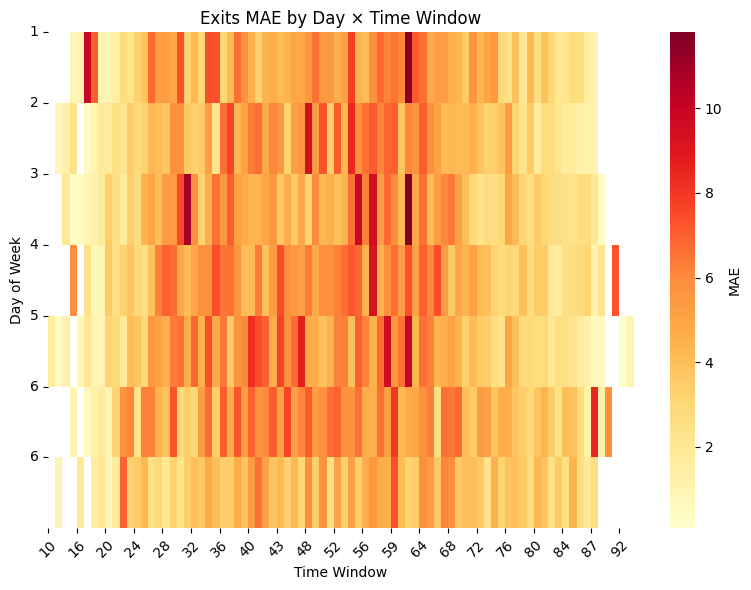

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Zone × Day of Week
pivot_zone_day_entries = mae_by_zone_day.pivot(index="zone_codes", columns="datetime_day_week", values="y_true_entries_score")
pivot_zone_day_exits   = mae_by_zone_day.pivot(index="zone_codes", columns="datetime_day_week", values="y_true_exits_score")

def format_axis_ticks(ax, decimals=0):
    """Round tick labels on both axes"""
    ax.set_xticklabels([f"{tick:.{decimals}f}" if isinstance(tick, (int,float)) else tick for tick in ax.get_xticks()])
    ax.set_yticklabels([f"{tick:.{decimals}f}" if isinstance(tick, (int,float)) else tick for tick in ax.get_yticks()])

# Example: Zone × Day (Entries)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_day_entries, cmap="YlGnBu", annot=False)
plt.title("Entries MAE by Zone × Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Zone")
# format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_day_exits, cmap="YlOrRd", annot=False)
plt.title("Exits MAE by Zone × Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Zone")
# format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()


# 2. Zone × Time Window
pivot_zone_time_entries = mae_by_zone_time.pivot(index="zone_codes", columns="datetime_W", values="y_true_entries_score")
pivot_zone_time_exits   = mae_by_zone_time.pivot(index="zone_codes", columns="datetime_W", values="y_true_exits_score")

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_time_entries, cmap="YlGnBu", annot=False)
plt.title("Entries MAE by Zone × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Zone")
format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_zone_time_exits, cmap="YlOrRd", annot=False)
plt.title("Exits MAE by Zone × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Zone")
format_axis_ticks(ax, decimals=0)   # round to integers
plt.show()

# 3. Day of Week × Time Window
pivot_day_time_entries = mae_by_day_time.pivot(index="datetime_day_week", columns="datetime_W", values="y_true_entries_score")
pivot_day_time_exits   = mae_by_day_time.pivot(index="datetime_day_week", columns="datetime_W", values="y_true_exits_score")


plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_day_time_entries, cmap="YlGnBu", annot=False, cbar_kws={'label': 'MAE'})
plt.title("Entries MAE by Day × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Day of Week")
ax.set_xticks(range(0, len(pivot_day_time_entries.columns), 4))  # show every 4th time window (adjust as needed)
ax.set_xticklabels(pivot_day_time_entries.columns[::4].astype(int), rotation=45)
ax.set_yticks(range(len(pivot_day_time_entries.index)))
ax.set_yticklabels(pivot_day_time_entries.index.astype(int))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_day_time_exits, cmap="YlOrRd", annot=False, cbar_kws={'label': 'MAE'})
plt.title("Exits MAE by Day × Time Window")
plt.xlabel("Time Window")
plt.ylabel("Day of Week")
ax.set_xticks(range(0, len(pivot_day_time_exits.columns), 4))  # show every 4th time window (adjust as needed)
ax.set_xticklabels(pivot_day_time_exits.columns[::4].astype(int), rotation=45)
ax.set_yticks(range(len(pivot_day_time_exits.index)))
ax.set_yticklabels(pivot_day_time_exits.index.astype(int))
plt.tight_layout()
plt.show()


Multidimensionality

In [61]:
# Compute mean MAE across subgroups in each dimension
avg_day = mae_by_day_week[['y_true_entries_score', 'y_true_exits_score']].mean()
avg_time = mae_by_datetime_W[['y_true_entries_score', 'y_true_exits_score']].mean()
avg_zone = mae_by_zone_codes[['y_true_entries_score', 'y_true_exits_score']].mean()

avg_mae_summary = pd.DataFrame({
    'Dimension': ['Day of Week', 'Datetime Winddow', 'Zone'],
    'Avg Entry MAE': [avg_day['y_true_entries_score'], avg_time['y_true_entries_score'], avg_zone['y_true_entries_score']],
    'Avg Exit MAE': [avg_day['y_true_exits_score'], avg_time['y_true_exits_score'], avg_zone['y_true_exits_score']]
})
avg_mae_summary.head(10)

,Dimension,Avg Entry MAE,Avg Exit MAE
0,Day of Week,5.296962,4.728614
1,Datetime Winddow,4.702660,4.207081
2,Zone,4.801512,4.303432
